In [14]:
!pip list

Package                               Version    
------------------------------------- -----------
adal                                  1.0.2      
alabaster                             0.7.10     
altair                                2.1.0      
anaconda-client                       1.6.5      
anaconda-navigator                    1.6.9      
anaconda-project                      0.8.0      
applicationinsights                   0.11.5     
argcomplete                           1.9.4      
arrow                                 0.12.1     
asn1crypto                            0.22.0     
astroid                               1.5.3      
astropy                               2.0.2      
attrs                                 18.1.0     
Automat                               0.7.0      
azure-batch                           4.1.3      
azure-cli                             2.0.43     
azure-cli-acr                         2.1.2      
azure-cli-acs                         2.1.2      


Keras                                 2.2.2      
Keras-Applications                    1.0.2      
Keras-Preprocessing                   1.0.1      
keyring                               13.2.1     
klein                                 17.10.0    
knack                                 0.3.3      
lazy-object-proxy                     1.3.1      
line-profiler                         2.1.2      
llvmlite                              0.20.0     
locket                                0.2.0      
lockfile                              0.12.2     
luigi                                 2.7.6      
lxml                                  4.1.0      
MarkupSafe                            1.0        
matplotlib                            2.1.1      
mccabe                                0.6.1      
memory-profiler                       0.52.0     
mistune                               0.7.4      
mock                                  2.0.0      
mpmath                                0.19       


In [2]:
import tushare as ts

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
import pandas as pd

In [5]:
df=ts.get_stock_basics()

In [6]:
df[['name','outstanding','timeToMarket']].head()

,name,outstanding,timeToMarket
code,,,
002447,晨鑫科技,11.50,20100713
000971,高升控股,5.91,20000427
300299,富春股份,5.84,20120319
300193,佳士科技,4.58,20110322
002766,索菱股份,2.49,20150611


In [7]:
df.columns

Index(['name', 'industry', 'area', 'pe', 'outstanding', 'totals',
       'totalAssets', 'liquidAssets', 'fixedAssets', 'reserved',
       'reservedPerShare', 'esp', 'bvps', 'pb', 'timeToMarket', 'undp',
       'perundp', 'rev', 'profit', 'gpr', 'npr', 'holders'],
      dtype='object')

In [142]:
code='002628'
cons = ts.get_apis()
df_days = ts.bar('000409', conn=cons, adj='qfq', start_date='2018-02-01', end_date='2018-08-31')

In [8]:
def bollinger_bands(df, n=20, k=1.96):
    df['ma']=df['close_q'].rolling(window=n).mean()
    df['std']=df['close_q'].rolling(window=n).std()
    df['bb_down']=df['ma']-df['std']*k
    df['bb_up']=df['ma']+df['std']*k
    df['pb']=(df['close_q']-df['bb_down'])/(df['std']*2*k)
    df['bw']=df['std']*2*k/df['ma']
    return df

In [9]:
def getBuyDates(df):
    result=[]
    record=None
    state = ''
    for index, row in df.iterrows():
        if row['pb']>=0:
            if state == 'down_band':
                state = 'cross1'
                cross_close1 = row['close_q']

            elif state == 'cross1':
                state = 'canbuy'
                close_mom = row['close_q'] / cross_close1
                ma_mom = row['ma'] / last_ma
#                 if ma_mom > 0.998:
                record={
                    "date": index,
                    "close": row['close_q'],
                    "ma": row['ma'],
                    "close_mom": close_mom,
                    "ma_mom": ma_mom,
                    "pb": row['pb'],
                    "bw": row['bw']
                }
                days_intval = 1

                state = ''
                result.append(record)
            elif state == 'canbuy':
                open=row['open_q']
                target_price = record[1]
                ma_deal_mom = row['ma'] / last_ma
                if open<=target_price and days_intval==1:
                    record.append((open + record[1])/2)
                    record.append(0)
                    record.append(ma_deal_mom)
                    result.append(record)
                    record = None
                    state = ''
                else:
                    avg=row['avg_fq']
                    deal_price = round(avg - (avg-row['low_q'])*0.1, 2)
                    if deal_price <= target_price * 1.030 and deal_price >= target_price * 0.99 and row['pb'] <= 0.6:
                        record.append(deal_price)
                        record.append(days_intval)
                        record.append(ma_deal_mom)
                        result.append(record)
                        record = None
                        state = ''
                days_intval+=1

            last_ma = row['ma']
        if row['pb']<0:
            state = 'down_band'
    return result

In [10]:
def genData(code):
    df_stock=pd.read_csv('./data/%s.csv'%(code), index_col='datetime', parse_dates=['datetime'], dtype={'code':'object'})
    df_bb = bollinger_bands(df_stock)
    buy_dates = getBuyDates(df_bb)
    for item in buy_dates[:5]:
        date = item['date']
        df1 = df_stock.loc[df_stock.index > date][0:5]
        i = 0
        for index, row in df1.iterrows():
            i += 1
            deal_price = row['avg_fq'] + (row['high_q'] - row['avg_fq'])*0.1
            item['sell%d'%(i)]=deal_price
    return buy_dates

In [ ]:
def gen():
    df_stocks=pd.read_csv('./data/')

In [243]:
buys=genData('000159')
buys[:10]

[{'bw': 0.5854200633125758,
  'close': 5.9,
  'close_mom': 1.0034013605442178,
  'date': Timestamp('2008-08-14 00:00:00'),
  'ma': 7.501500000000003,
  'ma_mom': 0.9834808259587021,
  'pb': 0.1353206038100844,
  'sell1': 5.776304648484065,
  'sell2': 5.339220001010861,
  'sell3': 5.147906040695869,
  'sell4': 5.574694830849488,
  'sell5': 5.469233313117235},
 {'bw': 0.5055256009001834,
  'close': 3.0,
  'close_mom': 1.0526315789473684,
  'date': Timestamp('2008-10-20 00:00:00'),
  'ma': 3.5615000000000023,
  'ma_mom': 0.9902683164187404,
  'pb': 0.18812995866957258,
  'sell1': 3.0639546736510854,
  'sell2': 2.936621339613792,
  'sell3': 2.8348461863210996,
  'sell4': 3.2400011923449004,
  'sell5': 3.557597643415007},
 {'bw': 0.28746927857411014,
  'close': 3.8,
  'close_mom': 1.0133333333333332,
  'date': Timestamp('2008-12-26 00:00:00'),
  'ma': 4.311000000000002,
  'ma_mom': 0.9975702880944116,
  'pb': 0.08766382473092248,
  'sell1': 3.706171802622225,
  'sell2': 3.7424001036235834,


In [11]:
code='000159'
df_stock=pd.read_csv('./data/%s.csv'%(code), index_col='datetime', parse_dates=['datetime'], dtype={'code':'object'})
df=bollinger_bands(df_stock)

In [12]:
df.tail(2)

,code,open,close,high,low,vol,amount,p_change,avg,open_q,close_q,high_q,low_q,avg_fq,ma,std,bb_down,bb_up,pb,bw
datetime,,,,,,,,,,,,,,,,,,,,
2018-06-28,000159,3.64,3.55,3.64,3.55,20663.0,7429947.5,-1.39,3.595774,3.64,3.55,3.64,3.55,3.595774,3.8420,0.279503,3.294173,4.389827,0.233492,0.285178
2018-06-29,000159,3.57,3.65,3.66,3.55,26706.0,9669437.0,2.82,3.620698,3.57,3.65,3.66,3.55,3.620698,3.8165,0.272131,3.283122,4.349878,0.343919,0.279511


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


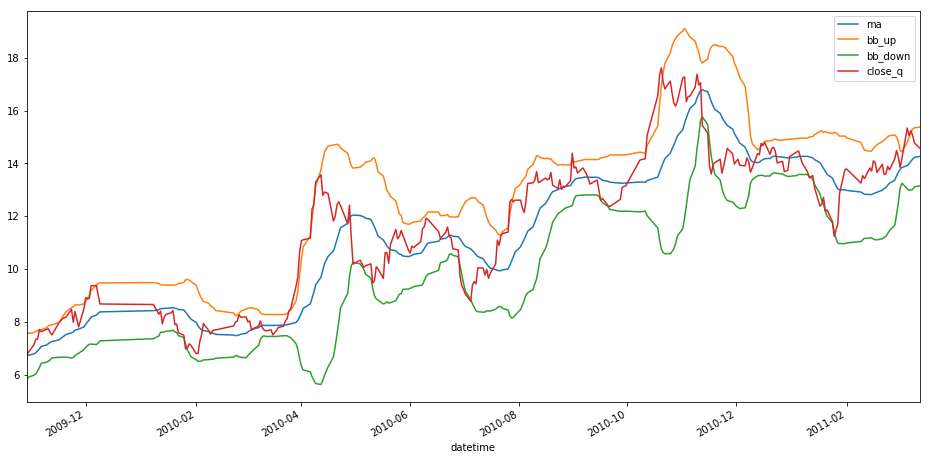

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8
df[300:600][['ma','bb_up', 'bb_down', 'close_q']].plot();

In [270]:
df_days.loc['2016-09-30']

open       1.709000e+01
high       1.799000e+01
close      1.728000e+01
low        1.698000e+01
volume     2.954280e+07
amount     4.079208e+08
ma         1.476750e+01
std        1.437618e+00
bb_down    1.217979e+01
bb_up      1.735521e+01
pb         9.854673e-01
bw         3.504605e-01
Name: 2016-09-30 00:00:00, dtype: float64

In [60]:
# df_days['test']=df_days.apply(lambda row: row['amount']/row['volume'], axis=1)
n=2
df_n = df_days[0:n-1]
# for index, row in df_days.iterrows():
#     print(index)
df_days

,open,high,close,low,volume,amount
date,,,,,,
2017-01-03,8.79,8.87,8.77,8.70,7688437.0,72531222.0
2017-01-04,8.78,8.83,8.80,8.64,11149422.0,104182233.0
2017-01-05,8.76,8.80,8.80,8.67,5772849.0,54311747.0
2017-01-06,8.84,8.98,8.74,8.73,8586536.0,81401026.0
2017-01-09,8.70,8.73,8.53,8.49,10812073.0,99271824.0
2017-01-10,8.49,8.56,8.51,8.36,7505586.0,68375813.0
2017-01-11,8.49,8.57,8.51,8.47,4786444.0,43828976.0
2017-01-12,8.55,8.57,8.48,8.41,5027115.0,45758240.0
2017-01-13,8.47,8.54,8.16,8.02,6130600.0,54975486.0


In [14]:
from pandas.io import sql
import MySQLdb

con = MySQLdb.connect()
df.to_sql(con=con, name='table_name_for_df', if_exists='replace', flavor='mysql')

603871
300644
000816
600202
300739
601069
300451
002837
603516
603506
601838
002926
002848
600186
002840
600988
000681
300343
300641
600821
600398
002688
002207
000544
300737
600359
000048
300484
300287
002237
002155
600137
300348
300212
300618
600396
002077
002336
002015
000880
600489
300423
002583
600779
002644
002547
600547
600903
300298
300506
000632
002660
601567
600408
000710
000592
600653
300503
002925
000596
002020
300420
002399
603323
000909
603787
002519
603589
300676
603169
000982
002897
600336
600146
600853
000875
000966
002100
002735
002769
600671
600460
603360
000902
002505
603578
002765
000528
002023
603081
002723
002725
600311
300176
000687
002252
300459
300686
002666
603086
600280
002468
601828
002716
300401
002459
600455
300725
603998
603996
603988
603986
603887
603822
603730
603718
603699
603667
603603
603598
603520
603398
603359
603318
603309
603088
603079
603077
603066
603033
603032
603028
603021
601988
601985
601766
601669
601633
601619
601600
601390
601369
601328

600597
002024
000718
000068
600691
600850
002460
600381
000990
000650
002873
000833
300256
000828
002428
600812
603308
600770
603038
601100
300190
002461
300204
600110
002117
300683
600490
600116
603908
603868
601366
600589
000652
002337
002888
002099
300364
600428
600250
603027
000666
300221
000061
603669
000607
600805
300302
002808
002582
000897
002546
002415
000430
600739
601880
002668
600109
002810
601137
603258
603099
000059
002803
600873
600386
002508
000906
300226
300303
300095
600639
600768
300012
601666
300347
600995
600624
002632
600537
002062
002502
603040
300158
300530
000987
603663
603877
300147
002429
300206
603168
603626
600894
603100
300415
002296
603303
002030
300660
002689
000919
601333
000933
603387
603003
300015
002238
603288
600657
600823
002608
300472
603901
000758
000585
000514
600893
002654
000609
600679
600584
000725
000021
002374
300011
600305
600530
002364
600300
603300
600909
300577
002078
600830
600513
600543
300476
000617
600098
300139
600161
002554
601900